# Prelim

In [80]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy import stats

import xgboost as xgb
from xgboost import cv
from xgboost import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [81]:
train               = pd.merge(
                                pd.read_csv('data/train.csv') , 
                                pd.read_csv('data/training_extra.csv'), 
                                how='outer'
                                )
test                = pd.read_csv('data/test.csv')
sample_submission   = pd.read_csv('data/sample_submission.csv')

In [82]:
train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [89]:
#helper functions 
def generate_submission(sub):
    i=0
    while os.path.exists('submissions/submission%s.csv' % i):
        i+=1

    filepath = 'submissions/submission%s.csv' % i
    sub.to_csv(filepath, index=False)

def encode_cats(data):
    non_numeric_cols = list(data.select_dtypes(exclude=np.number).columns)
    data[non_numeric_cols] = data[non_numeric_cols].astype('category').apply(lambda x: x.cat.codes)
    return data

def plot_gain_importance(xgb_model):

    gain = xgb_model.get_booster().get_score(importance_type='gain')

    keys = list(gain.keys())
    values = list(gain.values())

    plt.figure(figsize=(30, 6))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Dictionary Plot')
    plt.grid(axis='y', linestyle='--')
    plt.show()

def plot_weight_importance(xgb_model):

    gain = xgb_model.get_booster().get_score(importance_type='weight')

    keys = list(gain.keys())
    values = list(gain.values())

    plt.figure(figsize=(30, 6))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Dictionary Plot')
    plt.grid(axis='y', linestyle='--')
    plt.show()

def feature_adjustment(df):
    try:
        df.drop(columns=['Price'], inplace=True)
    except KeyError:
        pass

    try:
        df.drop(columns=['id'], inplace=True)
    except KeyError:
        pass

    # try:
    #     df.drop(columns=['Color'])
    # except KeyError:
    #     pass

    encode_cats(df)
    gain_2 = pd.read_csv('gain_importance_2.csv').filter(list(df.columns))
    # naive_gain_importance = pd.read_csv('data/naive_gain_importance.csv')
    
    # df['log weight cap'] = np.log(df['Weight Capacity (kg)'])
    df['weight cap squared'] = df['Weight Capacity (kg)'] ** 2
    # df['avg_wgt_by_gain'] = df[list(gain_2.columns)].dot( gain_2.transpose()).div( gain_2.sum(axis=1)) 
    # df['naive_weighted_avg'] = df[list(naive_gain_importance.columns)].dot( naive_gain_importance.transpose()).div( naive_gain_importance.sum(axis=1))
    df['water_and_weight'] = df['Waterproof'] * df['Weight Capacity (kg)'] 
    df['laptop_and_weight'] = df['Laptop Compartment'] * df['Weight Capacity (kg)'] 

def get_current_winner():
    WINNER = 'model_2'
    winner = xgb.XGBRegressor()
    booster = xgb.Booster()
    booster.load_model('models/' + WINNER + '.json')
    winner.booster = booster
    return winner

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

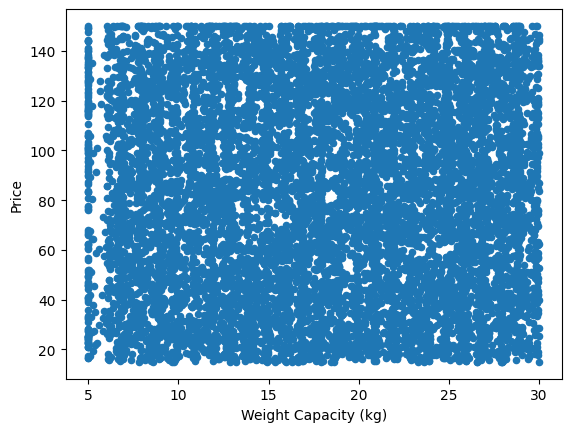

In [23]:
nums = train.select_dtypes(include=np.number)
nums[nums['Compartments'] == 8].sample(10000).plot.scatter(x='Weight Capacity (kg)', y='Price')

array([[<Axes: title={'center': 'Weight Capacity (kg)'}>]], dtype=object)

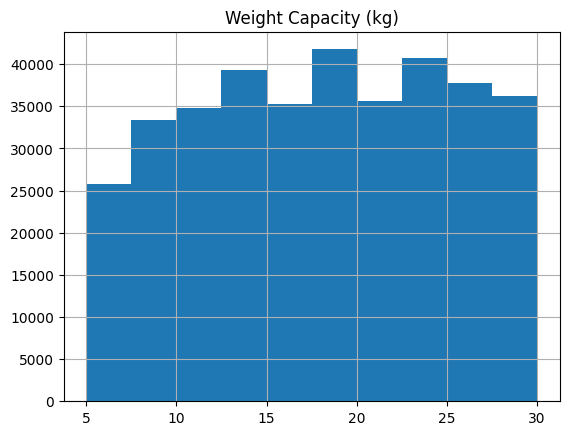

In [24]:
nums[nums['Compartments'] == 6].hist(column='Weight Capacity (kg)')

In [ ]:
from scipy.stats import chi2_contingency
import seaborn as sns

def ch_calculate(df):
    factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

    chi2, p_values =[], []

    for f in factors_paired:
        if f[0] != f[1]:
            chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
            chi2.append(chitest[0])
            p_values.append(chitest[1])
        else:      # for same factor pair
            chi2.append(0)
            p_values.append(0)

    chi2 = np.array(chi2).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience
    #all the p-values are essentially zero
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(chi2, annot = True)
    plt.show()
    

In [374]:
ch_calculate(X[['Material', 'Brand', 'Size', 'Waterproof', 'Style']])

(              Material       Brand        Size  Waterproof       Style
 Material      0.000000  791.111180  823.019600  601.734078  447.886985
 Brand       791.111180    0.000000  551.488094  998.784813  457.219329
 Size        823.019600  551.488094    0.000000  177.764152  453.549063
 Waterproof  601.734078  998.784813  177.764152    0.000000  583.373571
 Style       447.886985  457.219329  453.549063  583.373571    0.000000,
 [0,
  np.float64(1.09009452073795e-154),
  np.float64(1.9124074993801015e-168),
  np.float64(9.917799158987154e-125),
  np.float64(2.6536859887839776e-88),
  np.float64(1.0900945207378259e-154),
  0,
  np.float64(7.036562404569045e-108),
  np.float64(3.41724045095706e-208),
  np.float64(6.173572856958006e-88),
  np.float64(1.912407499379992e-168),
  np.float64(7.036562404569045e-108),
  0,
  np.float64(1.0124527907716746e-35),
  np.float64(4.9972707522498776e-92),
  np.float64(9.917799158987154e-125),
  np.float64(3.41724045095706e-208),
  np.float64(1.0124527

In [342]:
nums[nums.columns[1:]].corr()['Price'][:]

Compartments           -0.000691
Weight Capacity (kg)    0.017703
Price                   1.000000
Name: Price, dtype: float64

In [90]:
X = train.copy(deep=True)
y = train['Price'].copy(deep=True)
feature_adjustment(X)

In [91]:
model = xgb.XGBRegressor(
                    device='cuda',
                    n_estimators = 2000,
                    max_depth = 6,
                    learning_rate= .01,
                    objective='reg:squarederror',
                    early_stopping_rounds=20
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
model.fit( X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)]) 

[0]	validation_0-rmse:38.94043	validation_1-rmse:38.91554
[1]	validation_0-rmse:38.93970	validation_1-rmse:38.91491
[2]	validation_0-rmse:38.93898	validation_1-rmse:38.91429
[3]	validation_0-rmse:38.93827	validation_1-rmse:38.91369
[4]	validation_0-rmse:38.93758	validation_1-rmse:38.91309
[5]	validation_0-rmse:38.93692	validation_1-rmse:38.91253
[6]	validation_0-rmse:38.93625	validation_1-rmse:38.91196
[7]	validation_0-rmse:38.93561	validation_1-rmse:38.91142
[8]	validation_0-rmse:38.93497	validation_1-rmse:38.91087
[9]	validation_0-rmse:38.93435	validation_1-rmse:38.91035
[10]	validation_0-rmse:38.93373	validation_1-rmse:38.90982
[11]	validation_0-rmse:38.93314	validation_1-rmse:38.90932
[12]	validation_0-rmse:38.93254	validation_1-rmse:38.90881
[13]	validation_0-rmse:38.93197	validation_1-rmse:38.90834
[14]	validation_0-rmse:38.93139	validation_1-rmse:38.90785
[15]	validation_0-rmse:38.93084	validation_1-rmse:38.90739
[16]	validation_0-rmse:38.93029	validation_1-rmse:38.90693
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

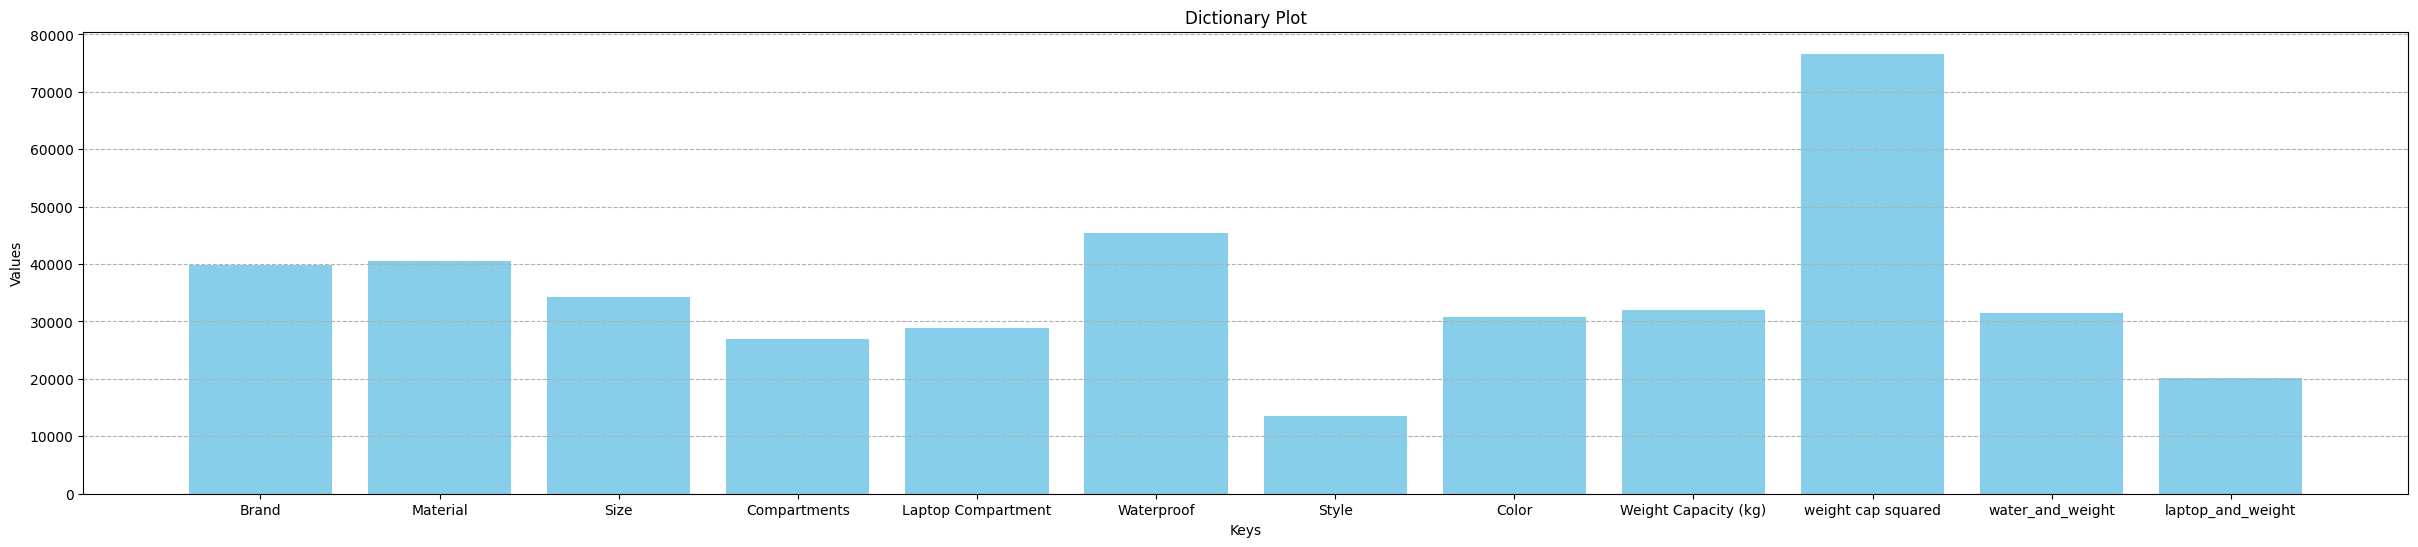

In [59]:
plot_gain_importance(model)

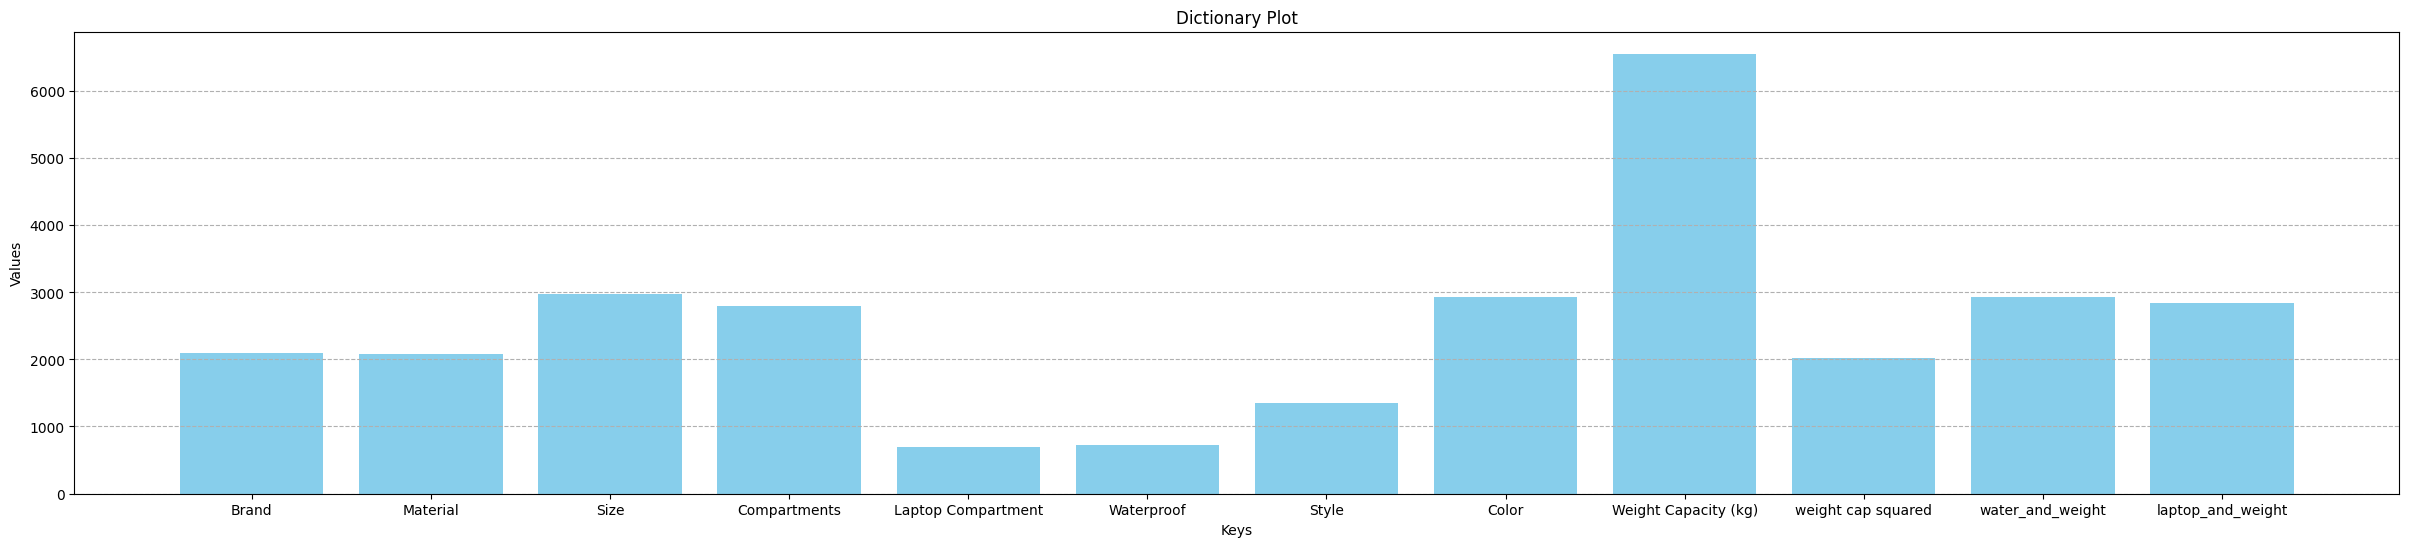

In [60]:
plot_weight_importance(model)

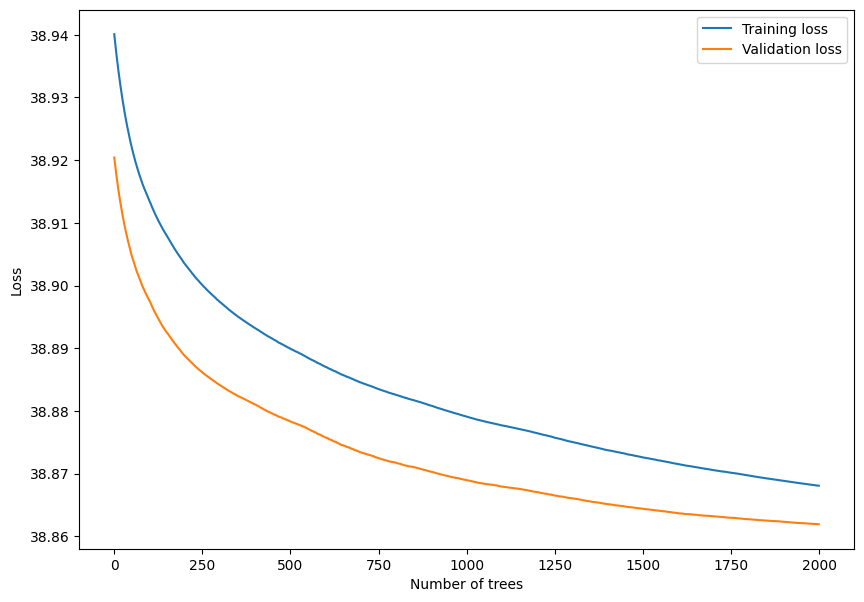

In [61]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [15]:
feature_adjustment(test)
sample_submission['Price'] = model.predict(test)
generate_submission(sample_submission)

c:\Users\19368\anaconda3\envs\Kaggle\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:08:48] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


average across Brand, Material, Size, Waterproof, Color and Weight Capacity (kg) was my best features, weighted by naive importance

In [ ]:
data = xgb.DMatrix(X, label=y)

params = {
    'objective':                'reg:squarederror',
    'max_depth' :               8,
    'learning_rate' :           .001,
}
cv_results = xgb.cv(
                    params,
                    data, 
                    nfold=5, 
                    metrics='rmse',
                    early_stopping_rounds=5
                        )

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,38.899895,0.004534,38.899900,0.018130
1,38.861151,0.004529,38.861156,0.018112
2,38.822446,0.004525,38.822451,0.018095
3,38.783779,0.004520,38.783784,0.018077
4,38.745151,0.004516,38.745156,0.018060
5,38.706562,0.004511,38.706567,0.018042
6,38.668012,0.004507,38.668017,0.018024
7,38.629501,0.004502,38.629506,0.018007
8,38.591027,0.004498,38.591032,0.017989
9,38.552593,0.004493,38.552598,0.017972


array([[<Axes: title={'center': 'Brand'}>,
        <Axes: title={'center': 'Material'}>,
        <Axes: title={'center': 'Size'}>],
       [<Axes: title={'center': 'Compartments'}>,
        <Axes: title={'center': 'Laptop Compartment'}>,
        <Axes: title={'center': 'Waterproof'}>],
       [<Axes: title={'center': 'Style'}>,
        <Axes: title={'center': 'Color'}>,
        <Axes: title={'center': 'Weight Capacity (kg)'}>],
       [<Axes: title={'center': 'log weight cap '}>,
        <Axes: title={'center': 'water_and_weight'}>,
        <Axes: title={'center': 'laptop_and_weight'}>]], dtype=object)

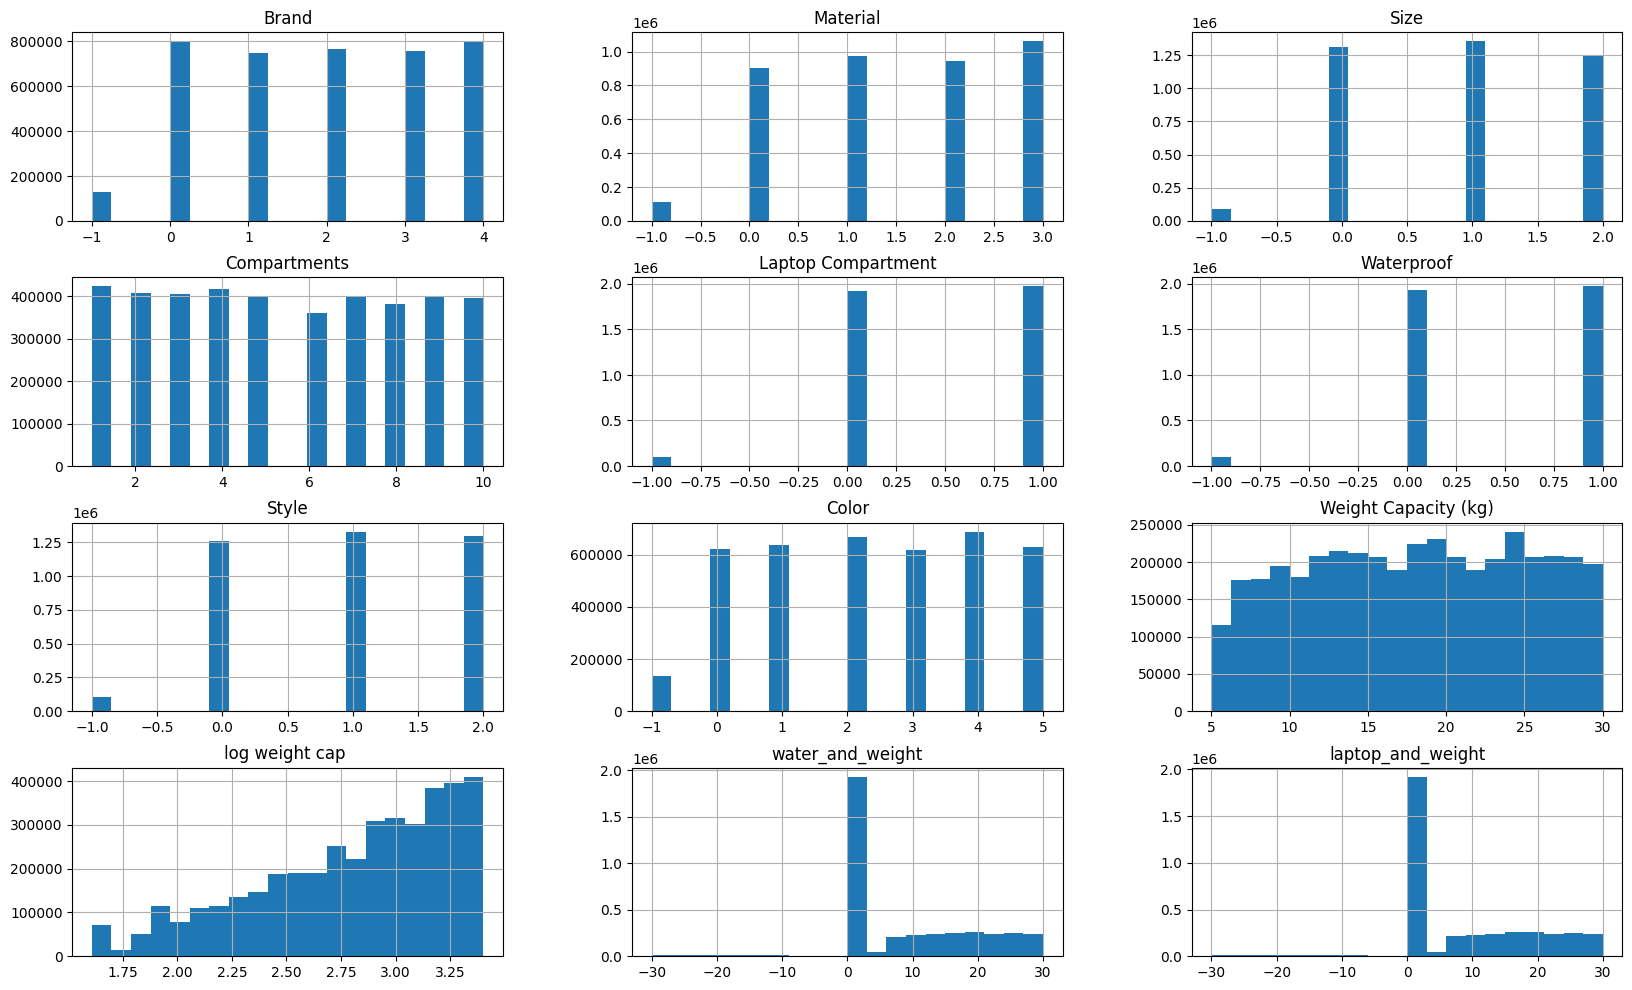

In [393]:
X.hist(figsize=(20,12), bins=20)